In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import numpy as np

from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline
display.set_matplotlib_formats('svg')

In [6]:
bs= 128
epochs=10
num_classes = 10
num_workers = 4
lr=0.1

def load_data(bs, num_workers):
    trans = transforms.ToTensor()
    train_data = datasets.MNIST(root='./data/', train=True, download=True, transform=trans)
    test_data = datasets.MNIST(root='./data/', train=False, download=True, transform=trans)
    
    train_loader = DataLoader(dataset=train_data, batch_size=bs, num_workers=num_workers, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=bs, num_workers=num_workers, shuffle=True)
    
    return train_loader, test_loader

class Net(nn.Module):

    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 1024),
            nn.Linear(1024, num_classes),

        )

    def forward(self,x):
        x = self.convnet(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = F.log_softmax(x, dim=1)

        return output
    
   

In [7]:
def accuracy(y_hat, y):
#     import pdb
#     pdb.set_trace()
    pred = (y == y_hat.argmax(dim=1)).float()
    mean_acc = pred.mean().item()
    
    pred[pred <1] = -1
    return pred.int()*(y+1), mean_acc

def evaluate(net, loader):
    accs = []
    net.eval()
    for idx, data in enumerate(loader):
        img, label = data
        output = net(img)
        corr_label, mean_acc = accuracy(output, label)
        accs.append(mean_acc)
        
    return np.mean(accs)

In [8]:
def train(epochs, lr, bs, num_classes, num_workers):
    net=Net()
    train_loader, test_loader = load_data(bs, num_workers)
    print(net)
    loss = nn.CrossEntropyLoss()
#     loss = nn.NLLLoss()
    optim = torch.optim.SGD(net.parameters(), lr = lr)
    
    train_loss, train_acc, test_acc, acc_per_cls = [], [], [], []
    for epo in range(epochs):
        epo_loss, epo_acc = [], []
        sum_img = np.array([0] * num_classes)
        correct_img = np.array([0] * num_classes)
        net.train()
        for idx, data in enumerate(train_loader):
            img, label = data
# because my Mac doesn't have GPU, I didn't write gpu version.
#             import pdb
#             pdb.set_trace()
            output = net(img)
            optim.zero_grad()
            iter_loss = loss(output, label)
            iter_loss.backward()
            optim.step()
#             import pdb
#             pdb.set_trace()
            corr_label, mean_acc = accuracy(output, label)
            for i in label:
                sum_img[i] += 1
                
            for i in corr_label:
                if i >= 0:
                    correct_img[i-1] += 1

            epo_loss.append(iter_loss.item())
            epo_acc.append(mean_acc)
            
        train_loss.append(np.mean(epo_loss))
        train_acc.append(np.mean(epo_acc))
        test_acc.append(evaluate(net, test_loader))
        acc_per_cls.append(list(correct_img/sum_img))
        
#         import pdb
#         pdb.set_trace()
        
        print(f'Epoch {epo} train loss: {train_loss[epo]}, train acc: {train_acc[epo]}, test acc: {test_acc[epo]}')
        print(f'Acc per class: {acc_per_cls[epo]} \n')

    return train_loss, train_acc, test_acc, acc_per_cls

train_loss, train_acc, test_acc, acc_per_cls = train(epochs, lr, bs, num_classes, num_workers)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Net(
  (convnet): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=10, bias=True)
  )
)





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch 0 train loss: 0.31257472458932956, train acc: 0.9058057925086032, test acc: 0.9714200949367089
Acc per class: [0.9569474928245821, 0.9584692969445269, 0.8905673044645854, 0.8846843908008482, 0.9010612803834304, 0.8780667773473528, 0.9351132139236229, 0.9128491620111732, 0.8631003247308152, 0.8672045721970079] 

Epoch 1 train loss: 0.07951349005905359, train acc: 0.9760183458135072, test acc: 0.9805181962025317
Acc per class: [0.9864933310822218, 0.9857609018095521, 0.9754951325948304, 0.966074049910292, 0.9796302636083533, 0.9760191846522782, 0.9859749915511997, 0.9766959297685555, 0.9623995898137071, 0.9645318540931249] 

Epoch 2 train loss: 0.05731441840124346, train acc: 0.9825593017057569, test acc: 0.9849683544303798
Acc per class: [0.9903764983960831, 0.9890240284781964, 0.9815374286673381, 0.9776545424889904, 0.985450188291681, 0.9802619442907212, 0.9907063197026023, 0.9822825219473265, 0.9731669800034182, 0.9741132963523281] 

Epoch 3 train loss: 0.04720367890284228, trai

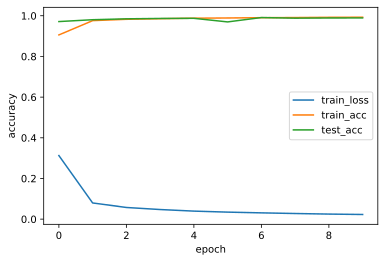

In [19]:
def visual(train_loss, train_acc, test_acc):
    x = range(len(train_loss))
    plt.plot(x, train_loss, label='train_loss')
    plt.plot(x, train_acc, label='train_acc')
    plt.plot(x, test_acc, label='test_acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
visual(train_loss, train_acc, test_acc)

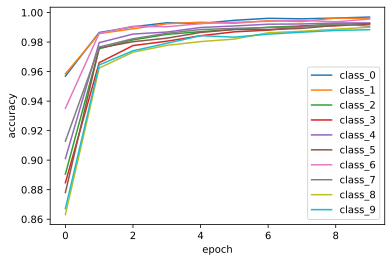

In [20]:
def visual_acc_per_cls(acc_per_cls):
    accs = np.array(acc_per_cls).T
    x = len(np.array(acc_per_cls).T)
    for i in range(x):
      plt.plot(range(x), accs[i], label='class_'+str(i))
    
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
visual_acc_per_cls(acc_per_cls)

In [15]:
len(np.array(acc_per_cls).T)

10